In [1]:
from DataFetcher import DataFetcher
from USTs import USTs
import datetime
import plotly.graph_objects as go

This repo uses data from the US Treasury for historical auctions and FedInvest for prices to get current and historical yield to maturity data for all outstanding US Treasury securities. This information can be used to screen for potential relative value trading opportunities. The current UST yield curve is plotted below along with its par curve. A quick inspection of the YTM distribution of the 300+ outstanding notes and bonds shows significant discrapancies in the 15-20 years to maturity region.

In [2]:
usts = USTs(date=datetime.date(2025, 7, 7))
ust_set = usts.get_current_UST_set(settlement_date=datetime.datetime(2025, 7, 8),
                                   get_ytms=True,
                                   include_FRNs=False,
                                   include_TIPS=False,
                                   include_outstanding=False)
usts.plot_ust_curve(bspline_curve=True, univariate_spline=False, mles_spline=False)

These discrepancies appear to have come about due to significant duration differences between these 20- and 30-year securities which were issued in periods with vastly different interest rate backdrops (Covid & post-GFC). Plotting the yields of this basket of securities  against their modified duration helps to illustrate this dynamic, with some of the first 20-year bonds issued in 2020 appearing very rich relative to other securities with similar duration profiles.

In [9]:
fig = go.Figure()
data = ust_set[(ust_set['Duration'] > 9) & (ust_set['Duration'] < 14)]
tenors = ['20-Year', '30-Year']

for tenor in tenors:
    plot_data = data[data['Security term'] == tenor]
    fig.add_trace(go.Scatter(
        x=plot_data['Duration'],
        y=plot_data['EOD YTM']/100,
        mode='markers+text',
        marker=dict(size=10),
        customdata=plot_data.reset_index().values,
        name=tenor,
        text=plot_data['Maturity date'].dt.strftime('%b-%y'),
        textposition='top center',
        textfont=dict(size=10)
    ))

fig.update_layout(
    title='Selected Treasury YTMs and Durations',
    width=900,
    height=500,
    margin=dict(l=20, r=20, t=50, b=20),
    xaxis_title='Duration (Years)',
    yaxis_title='End-of-Day Yield to Maturity (YTM)',
    yaxis=dict(tickformat='.2%', dtick=0.0005),
    legend_title_text='Security Tenors',
    template='plotly_dark'
)

This dynamic may provide relative value opportunities but due to the amount of securities outstanding, it may be difficult and cumbersome to screen for these opportunities manually. As such, a customisable screening tool could be valuable in helping to identify bonds which are trading cheap or rich relative to other bonds with similar maturities when adjusting for their duration profiles.

This tool screens all outstanding securities with 10+ years to maturity to look for potential relative value opportunities, returning 5 trading opportunities which have the widest spread relative to the slope of the par curve.

In [4]:
usts.get_initial_screening_set()

,Duration exposure,Current spread,Par curve spread,Long bond,Tenor,YTM,Short bond,Tenor,YTM
0,Long duration,10.4 bps,0.4 bps,2.875% May-43,30-Year,4.958319,1.125% May-40,20-Year,4.853981
1,Long duration,10.6 bps,2.0 bps,4.375% Nov-39,30-Year,4.730473,3.500% Feb-39,30-Year,4.624447
2,Long duration,16.9 bps,8.7 bps,4.750% Feb-41,30-Year,4.793395,3.500% Feb-39,30-Year,4.624447
3,Long duration,19.6 bps,13.6 bps,4.375% May-41,30-Year,4.820404,3.500% Feb-39,30-Year,4.624447
4,Long duration,17.2 bps,11.4 bps,4.250% Nov-40,30-Year,4.796193,3.500% Feb-39,30-Year,4.624447


Looking at the timeseries for these trades can also be helpful in assessing if the screened trades have displayed mean-reversion tendancies in recent trading. The plots below show a steepening trend with respect to the time to maturity. From this set of trades, the 4.375% May-41 / 3.500% Feb-39 flattener appears to be the most attractive, with the steepening appearing to be stretched given modest duration differences (11.1 vs 10.3). 

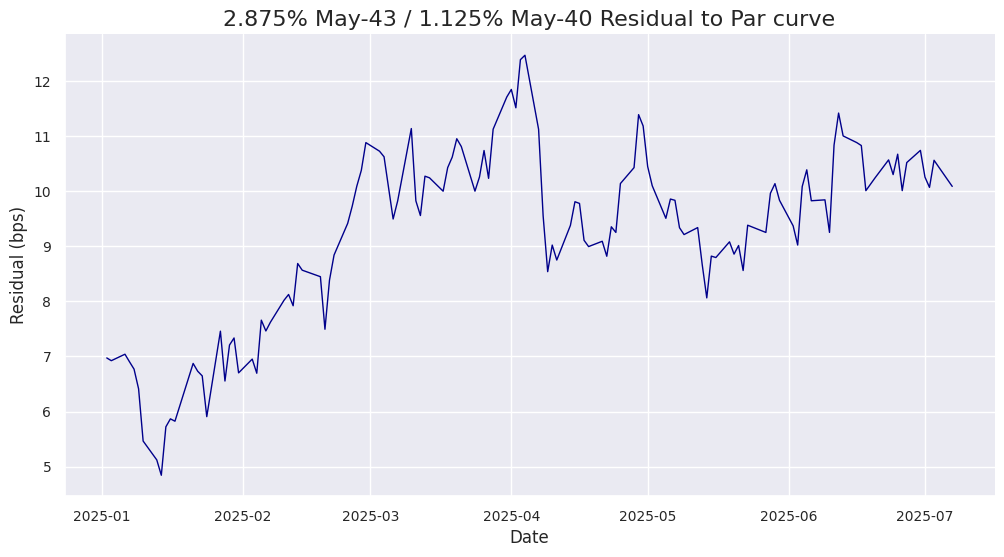

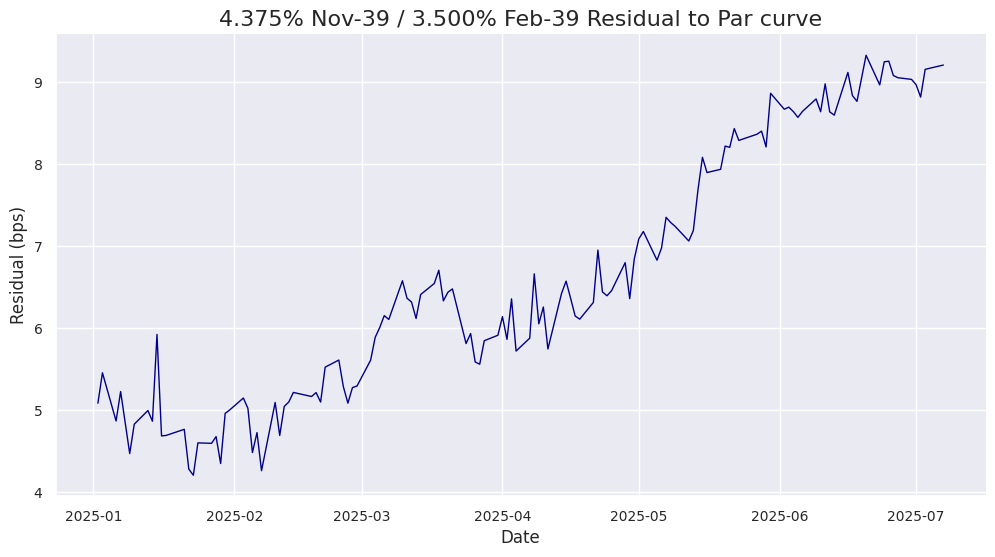

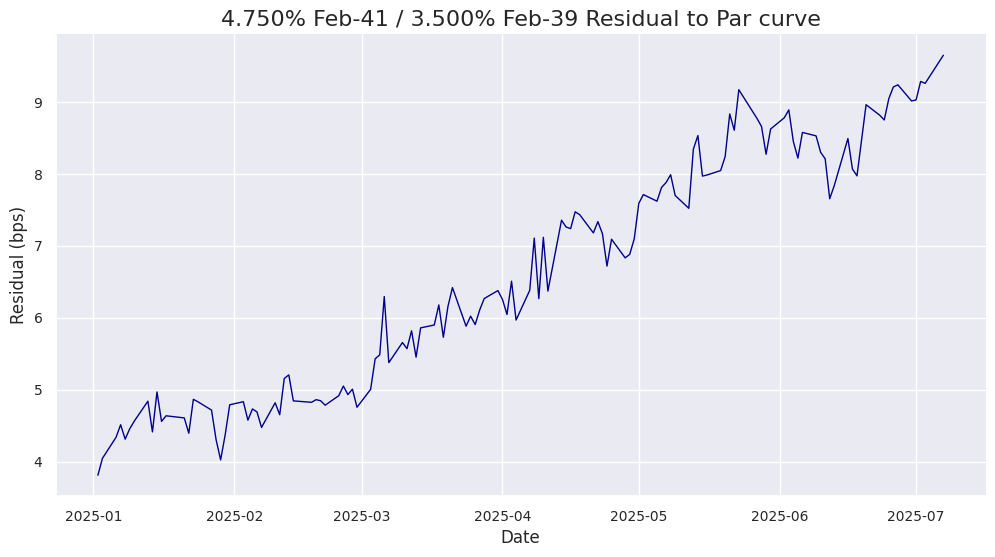

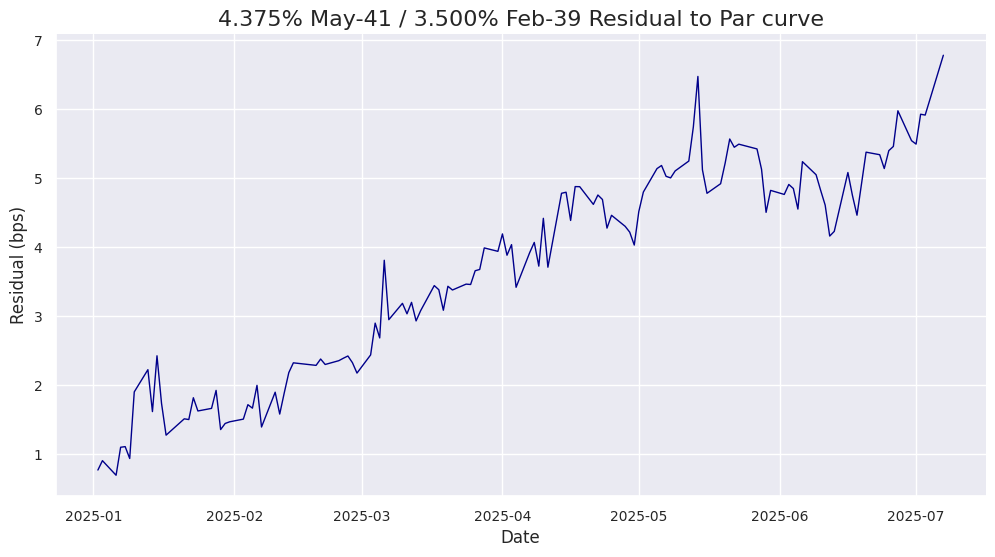

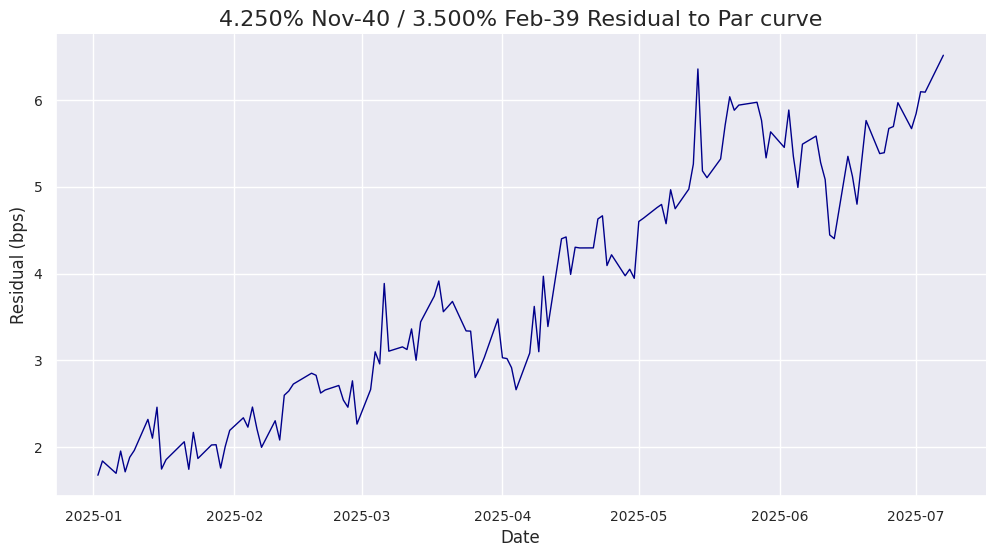

In [6]:
usts.plot_trade_timeseries(datetime.date(2025, 1, 1), datetime.date(2025, 7, 7))